In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, jaccard_score
import copy
import wandb
from tqdm import tqdm
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
import os
os.listdir('/kaggle/input/meat-freshness-image-dataset/Meat Freshness.v1-new-dataset.multiclass')

['README.dataset.txt', 'valid', 'train']

In [20]:
#Try the augmentation

import os
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset

class MeatDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.file_names = [f for f in os.listdir(data_dir) if f.endswith(".jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        img_path = os.path.join(self.data_dir, file_name)
        img_class = file_name.split("-")[0]

        # Load the image
        img = Image.open(img_path)

        # Apply the transforms
        if self.transform:
            img = self.transform(img)
            
        # Upsample image to 256x256
        img = transforms.Resize(256, InterpolationMode.BILINEAR)(img)

        # Convert the class label to a tensor
        label = torch.tensor(0, dtype=torch.float32)
        if img_class == "FRESH":
            label = torch.tensor(0, dtype=torch.float32)
        elif img_class == "HALF":
            label = torch.tensor(1, dtype=torch.float32)
        elif img_class == "SPOILED":
            label = torch.tensor(2, dtype=torch.float32)
        
        # Create segmentation mask by applying threshold
        img_gray = transforms.Grayscale()(img)
        threshold = 0.2
        mask = torch.zeros_like(img_gray, dtype=torch.float)
        mask[img_gray > threshold] = 1.0

        return img, mask, label

In [21]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet, self).__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottom = DoubleConv(512, 1024)

        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.upconv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upconv4 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # downsample path
        x1 = self.down1(x)
        x2 = self.pool1(x1)
        x2 = self.down2(x2)
        x3 = self.pool2(x2)
        x3 = self.down3(x3)
        x4 = self.pool3(x3)
        x4 = self.down4(x4)

        # bottom layer
        x5 = self.pool4(x4)
        x5 = self.bottom(x5)

        # upsample path
        x = self.up1(x5)
        x = torch.cat([x4, x], dim=1)
        x = self.upconv1(x)
        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.upconv2(x)
        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.upconv3(x)
        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.upconv4(x)

        # final output
        x = self.final(x)
        x = torch.sigmoid(x)
        return x

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x

In [22]:
class CustomNet(nn.Module):
    def __init__(self, dropout_prob=0.3):
        super(CustomNet, self).__init__()
        self.fc1 = nn.Linear(256*256*1, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        x = x.view(-1, 256*256*1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.softmax(self.fc3(x))
        return x

In [23]:
# Define the DiceLoss function
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets):
        # flatten the inputs and targets
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        # compute intersection and union
        intersection = (inputs * targets).sum()
        union = inputs.sum() + targets.sum()
        # compute the Dice coefficient
        dice = (2. * intersection + 1.) / (union + 1.)
        # compute the Dice loss
        loss = 1. - dice
        return loss

In [24]:
class JaccardLoss(torch.nn.Module):
    def __init__(self, smooth=1):
        super(JaccardLoss, self).__init__()
        self.smooth = smooth

    def forward(self, input, target):
        # Flatten both inputs
        input_flat = input.view(-1)
        target_flat = target.view(-1)

        # Calculate intersection and union
        intersection = (input_flat * target_flat).sum()
        union = input_flat.sum() + target_flat.sum() - intersection

        # Calculate Jaccard score and loss
        jaccard_score = (intersection + self.smooth) / (union + self.smooth)
        jaccard_loss = 1 - jaccard_score

        return jaccard_loss

In [27]:
# Will add to constants.json later the the hyperparameteres used here
model_name = "imgseg"
NUM_CLASSES = 3 # Number of classes in the dataset
BATCH_SIZE = 8
EPOCHS = 20
LEARNING_RATE = 0.001

# Define the loss function
criterion = JaccardLoss()

In [28]:
#Augmentation of the images

from torchvision import transforms

# Define the transforms for the training data
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the transform for the validation data
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [29]:
# Create the train and validation datasets
train_dir = '/kaggle/input/meat-freshness-image-dataset/Meat Freshness.v1-new-dataset.multiclass/train'
val_dir = '/kaggle/input/meat-freshness-image-dataset/Meat Freshness.v1-new-dataset.multiclass/valid'

meat_datasets = {"train": MeatDataset(train_dir, transform=train_transform),
                "val": MeatDataset(val_dir, transform=val_transform)}

meat_loaders ={"train": DataLoader(meat_datasets["train"], 
                        batch_size=BATCH_SIZE, shuffle=True),
            "val": DataLoader(meat_datasets["val"], 
                                batch_size=BATCH_SIZE, shuffle=False)}

In [35]:
# Instantiate the model
model = UNet(out_channels=1)

# Move the model to the device
model = model.to(device)

In [36]:
# define optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Modified Training loop

In [37]:
# iterate over data
max_epochs = 4

best_loss = 0.3
best_js = 0
best_model_wts = copy.deepcopy(model.state_dict())
for epoch in range(max_epochs):
    print(f"{epoch+1} / {max_epochs}")
    # train phase
    model.train()
    running_loss = 0
    running_js = 0
    for inputs, mask, targets in tqdm(meat_loaders['train'], desc='train'):
        inputs, mask, targets = inputs.to(device), mask.to(device), targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # Get model outputs and calculate loss
        outputs = model(inputs)
        loss = criterion(outputs, mask)
        loss.backward()
        optimizer.step()
        predicted_masks = torch.argmax(outputs, dim=1).cpu().numpy()
        true_masks = mask.cpu().numpy()
        running_js += jaccard_score(true_masks.ravel(), predicted_masks.ravel(), average='macro')
        # statistics
        running_loss += loss.item()
    epoch_loss = running_loss / len(meat_loaders['train'].dataset)
    epoch_js = running_js / len(meat_loaders['train'].dataset)
    print('Epoch {} Train Loss: {:.4f} Train Jaccard Score: {:.4f}'.format(epoch+1, epoch_loss, epoch_js))
    
    # eval phase
    model.eval()
    test_loss = 0
    test_js = 0
    with torch.no_grad():
        for inputs, mask, targets in tqdm(meat_loaders['val'], desc='val'):
            inputs, mask, targets = inputs.to(device), mask.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, mask)
            predicted_masks = torch.argmax(outputs, dim=1).cpu().numpy()
            true_masks = mask.cpu().numpy()
            test_js += jaccard_score(true_masks.ravel(), predicted_masks.ravel(), average='macro')
            test_loss += loss.item()
    epoch_test_loss = test_loss/len(meat_loaders['val'].dataset)
    epoch_test_js = test_js/len(meat_loaders['val'].dataset)
    print('Epoch {} Test Loss: {:.4f} Test Jaccard Score: {:.4f}'.format(epoch+1, epoch_test_loss, epoch_test_js))
    
    # deep copy the model
    if epoch_test_loss < best_loss:
        best_loss = epoch_test_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        print("saving model")

1 / 4


train: 100%|██████████| 227/227 [02:13<00:00,  1.70it/s]


Epoch 1 Train Loss: 0.0266 Train Jaccard Score: 0.0375


val: 100%|██████████| 57/57 [00:18<00:00,  3.01it/s]


Epoch 1 Test Loss: 0.0074 Test Jaccard Score: 0.0356
saving model
2 / 4


train: 100%|██████████| 227/227 [02:12<00:00,  1.71it/s]


Epoch 2 Train Loss: 0.0188 Train Jaccard Score: 0.0377


val: 100%|██████████| 57/57 [00:19<00:00,  2.96it/s]


Epoch 2 Test Loss: 0.0159 Test Jaccard Score: 0.0356
3 / 4


train: 100%|██████████| 227/227 [02:13<00:00,  1.70it/s]


Epoch 3 Train Loss: 0.0196 Train Jaccard Score: 0.0372


val: 100%|██████████| 57/57 [00:19<00:00,  2.94it/s]


Epoch 3 Test Loss: 0.0045 Test Jaccard Score: 0.0356
saving model
4 / 4


train: 100%|██████████| 227/227 [02:12<00:00,  1.71it/s]


Epoch 4 Train Loss: 0.0202 Train Jaccard Score: 0.0380


val: 100%|██████████| 57/57 [00:19<00:00,  2.94it/s]

Epoch 4 Test Loss: 0.0112 Test Jaccard Score: 0.0356


In [38]:
# load best model weights
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [40]:
nn_model = CustomNet()
nn_model = nn_model.to(device)

nn_optimizer = optim.AdamW(nn_model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

In [41]:
nn_epochs = 3

best_acc = 0
nn_best_model_wts = []
for epoch in range(nn_epochs):
    print(f"{epoch+1} / {nn_epochs}")
    # train phase
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for inputs, mask, targets in tqdm(meat_loaders['train'], desc='train'):
        inputs, targets = inputs.to(device), targets.to(device, dtype=torch.long)
        
        nn_optimizer.zero_grad()
        imgseg_output = model(inputs)
        imgseg_output = torch.round(imgseg_output)
        nn_output = nn_model(imgseg_output)
        nn_loss = loss_fn(nn_output, targets)
        nn_loss.backward()
        nn_optimizer.step()
        
        pred = torch.argmax(nn_output, dim=1).cpu().numpy()
        true = targets.cpu().numpy()
        
        epoch_loss += nn_loss.item()
        epoch_acc += (pred == true).sum()
        torch.cuda.empty_cache()
    
    epoch_loss = epoch_loss / len(meat_loaders['train'].dataset)
    epoch_acc = epoch_acc / len(meat_loaders['train'].dataset)
    print(f"Epoch: {epoch+1}, Loss: {epoch_loss+1}, Accuracy: {epoch_acc}")
    
    # eval phase
    model.eval()
    epoch_test_loss = 0
    epoch_test_acc = 0
    with torch.no_grad():
        for inputs, mask, targets in tqdm(meat_loaders['val'], desc='val'):
            inputs, targets = inputs.to(device), targets.to(device, dtype=torch.long)
            imgseg_output = model(inputs)
            imgseg_output = torch.round(imgseg_output)
            nn_output = nn_model(imgseg_output)
            nn_loss = loss_fn(nn_output, targets)
            pred = torch.argmax(nn_output, dim=1).cpu().numpy()
            true = targets.cpu().numpy()
            
            pred = torch.argmax(nn_output, dim=1).cpu().numpy()
            true = targets.cpu().numpy()

            epoch_loss += nn_loss.item()
            epoch_test_loss += nn_loss.item()
            epoch_test_acc += (pred == true).sum()
            torch.cuda.empty_cache()

        epoch_test_loss = epoch_test_loss / len(meat_loaders['val'].dataset)
        epoch_test_acc = epoch_test_acc / len(meat_loaders['val'].dataset)
        print(f"Epoch: {epoch+1}, Test Loss: {epoch_loss+1}, Test Accuracy: {epoch_test_acc}")
        
    # deep copy the model
    if epoch_test_acc > best_acc:
        best_acc = epoch_test_acc
        nn_best_model_wts = copy.deepcopy(nn_model.state_dict())
        print("saving model")

1 / 3


train: 100%|██████████| 227/227 [01:33<00:00,  2.42it/s]


Epoch: 1, Loss: 1.148134309102681, Accuracy: 0.36584022038567493


val: 100%|██████████| 57/57 [00:08<00:00,  6.35it/s]


Epoch: 1, Test Loss: 69.70549257402578, Test Accuracy: 0.352549889135255
saving model
2 / 3


train: 100%|██████████| 227/227 [01:31<00:00,  2.48it/s]


Epoch: 2, Loss: 1.150384902001741, Accuracy: 0.34765840220385674


val: 100%|██████████| 57/57 [00:08<00:00,  6.38it/s]


Epoch: 2, Test Loss: 69.70775973701609, Test Accuracy: 0.352549889135255
3 / 3


train: 100%|██████████| 227/227 [01:31<00:00,  2.48it/s]


Epoch: 3, Loss: 1.1503616082438424, Accuracy: 0.34765840220385674


val: 100%|██████████| 57/57 [00:09<00:00,  6.20it/s]

Epoch: 3, Test Loss: 69.70771987316694, Test Accuracy: 0.352549889135255


In [42]:
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, mask, targets in tqdm(meat_loaders['val'], desc='val'):
        inputs, targets = inputs.to(device), targets.to(device, dtype=torch.long)
        imgseg_output = model(inputs)
        imgseg_output = torch.round(imgseg_output)
        nn_output = nn_model(imgseg_output)
        nn_loss = loss_fn(nn_output, targets)
        pred = torch.argmax(nn_output, dim=1).cpu().numpy()
        true = targets.cpu().numpy()
        y_pred.extend(pred)
        y_true.extend(true)

val: 100%|██████████| 57/57 [00:08<00:00,  6.38it/s]


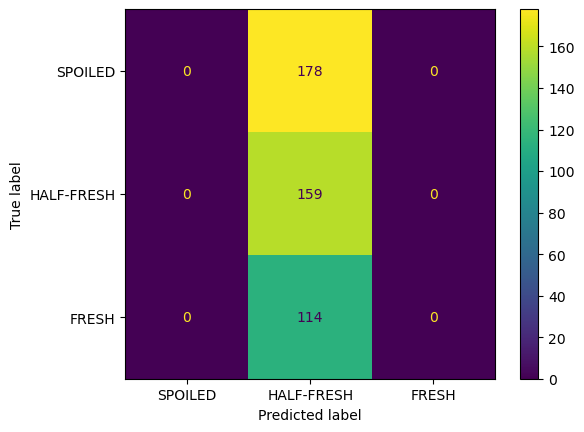

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['SPOILED', 'HALF-FRESH', 'FRESH'])
disp.plot(values_format = 'd')

plt.show()

In [55]:
print("precision score:", precision_score(y_pred, y_true, average='weighted'))
print("recall score:", recall_score(y_pred, y_true, average='weighted'))
print("f1 score:", f1_score(y_pred, y_true, average='weighted'))
print("accuracy score:", accuracy_score(y_pred, y_true))

precision score: 1.0
recall score: 0.352549889135255
f1 score: 0.521311475409836
accuracy score: 0.352549889135255


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model Output Interpretation

In [81]:
def img_disp(img_array1, img_array3):
    num_images = img_array1.shape[0]
    fig, axs = plt.subplots(num_images, 2, figsize=(15, 15))
    for i in range(num_images):
        if targets[i]==2:
            image1 = img_array1[i]
            image3 = img_array3[i]
            img_output1 = np.transpose(image1, (1, 2, 0))
            try:
                img_output3 = np.transpose(image3, (1, 2, 0))
            except:
                img_output3 = image3
            axs[i, 0].imshow(img_output1)
            axs[i, 1].imshow(img_output3)
            axs[i, 0].axis('off')
            axs[i, 1].axis('off')
        else:
            axs[i, 0].axis('off')
            axs[i, 1].axis('off')
    plt.show()

In [59]:
num_images = inputs.cpu().numpy().shape[0]
for i in range(num_images):
    if targets[i]==2:
        print(i)

2


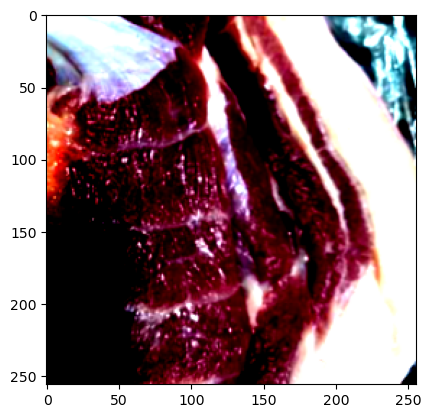

In [65]:
img = inputs.detach().cpu().numpy()[0]
plt.imshow(np.transpose(img, (1,2,0)))

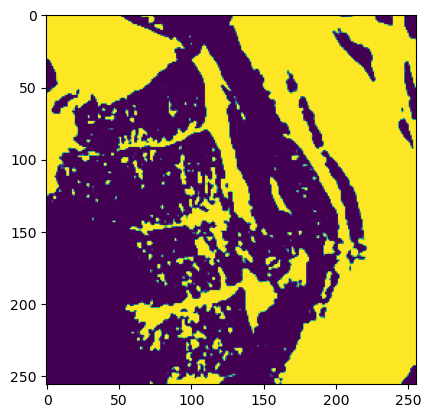

In [66]:
img = outputs.detach().cpu().numpy()[0]
plt.imshow(np.transpose(img, (1,2,0)))